# Прогноз оттока клиентов фитнес-клуба

## Постановка задачи

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  1. выделить целевые группы клиентов;
  1. предложить меры по снижению оттока;
  1. определить другие особенности взаимодействия с клиентами.

## Шаг 1. Обзор данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
* 'Churn' — факт оттока в текущем месяце;
* Данные пользователя за предыдущий до проверки факта оттока месяц:
  * 'gender' — пол
  * 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
  * 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
  * Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
  * 'Phone' — наличие контактного телефона
  * 'Age' — возраст
  * 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
  * 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
  * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
  * 'Group_visits' — факт посещения групповых занятий
  * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
  * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
  * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

Путь к файлу: /datasets/gym_churn.csv

Импортируем сразу все необходимые библиотеки и настройки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Прочитаем исходные данные в датафрейм и выведем общую информацию о них.

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В наших данных 14 столбцов, из них 1 целевая переменная Churn и 13 признаков. Всего наблюдений 4000, без явных пропусков. Категориальные признаки уже преобразованы в удобный для работы вид. Можем приступить к предобработке данных.

## Шаг 2. Исследовательский анализ данных (EDA)

План действий:

1. Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения (пригодится метод describe());
1. Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуемся методом groupby());
1. Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
1. Построим матрицу корреляций и отобразим её.

### 2.1. Описательные статистики данных

Выведем описательные статистики методом describe().

In [4]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Данные выглядят адекватно реальности. Отсутствующих признаков нет. Так, отсутствие телефона или частоты посещения групповых занятий - это не пропущенные данные, а информация о клиенте: не указал телефон или не ходил на групповые. Такая информация пригодится нам для обучения модели.

### 2.2. Средние значения признаков для ушедших в отток и оставшихся

Разделим датафрейм на два для удобства записи. Выделим записи о клиентах, ушедших в отток и тех, кто остался.

In [5]:
df_churn = df.query('Churn == 1')
df_churn.shape

(1061, 14)

In [6]:
df_stay = df.query('Churn == 0')
df_stay.shape

(2939, 14)

Видим, что оттоку подвержена четверть клиентов. Посмотрим на средние значения признаков в этих группах.

In [7]:
df_churn.mean()

gender                                 0.510839
Near_Location                          0.768143
Partner                                0.355325
Promo_friends                          0.183789
Phone                                  0.902922
Contract_period                        1.728558
Group_visits                           0.268615
Age                                   26.989632
Avg_additional_charges_total         115.082899
Month_to_end_contract                  1.662582
Lifetime                               0.990575
Avg_class_frequency_total              1.474995
Avg_class_frequency_current_month      1.044546
Churn                                  1.000000
dtype: float64

In [8]:
df_stay.mean()

gender                                 0.510037
Near_Location                          0.873086
Partner                                0.534195
Promo_friends                          0.353522
Phone                                  0.903709
Contract_period                        5.747193
Group_visits                           0.464103
Age                                   29.976523
Avg_additional_charges_total         158.445715
Month_to_end_contract                  5.283089
Lifetime                               4.711807
Avg_class_frequency_total              2.024876
Avg_class_frequency_current_month      2.027882
Churn                                  0.000000
dtype: float64

Уже по средним значениям видим, что оставшиеся клиенты в среднем живут ближе, пользуются скидкой или рекомендацией друзей, оформляют абонемент на больший период, активнее пользуются услугами клуба, а также "перешли" границу в 4 месяца посещений. Машинное обучение позволит нам выделить наиболее важные из этих признаков.

### 2.3. Столбчатые гистограммы и распределения признаков для ушедших в отток и оставшихся

Напишем функцию, которая будет строить гистаграммы признаков для заданного датафрейма.

In [9]:
def feature_hist(df):
    df_features = df.drop('Churn', axis=1)
    for column in df_features.columns:
        df_features[column].plot.hist(title=column)
        plt.show()

Вызовем функцию для датафрейма с ушедшими клиентами.

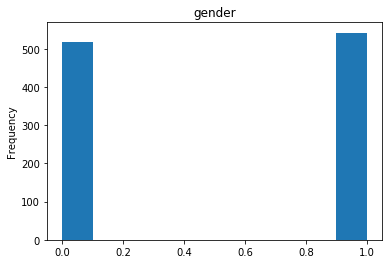

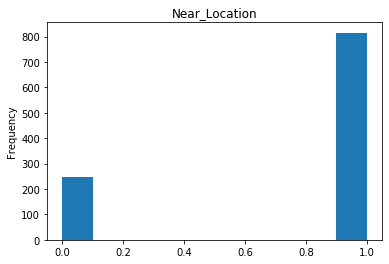

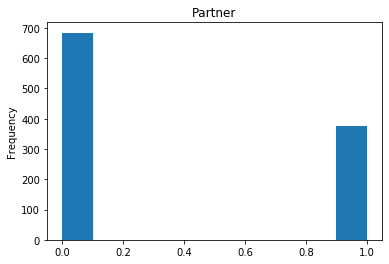

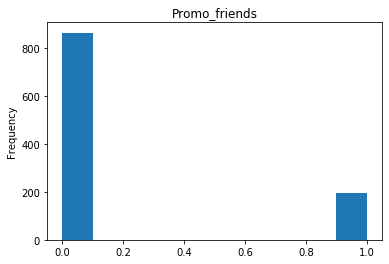

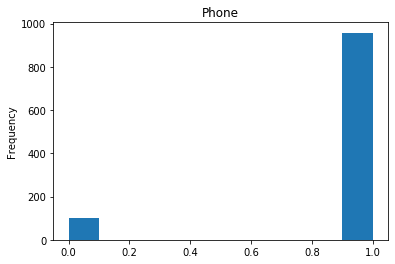

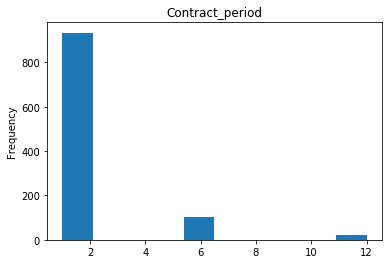

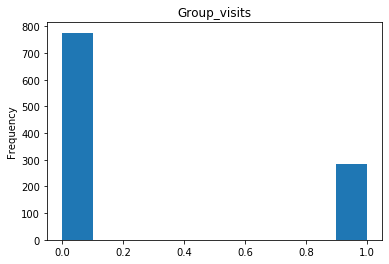

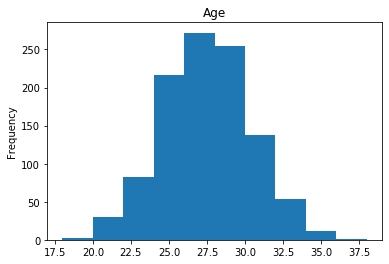

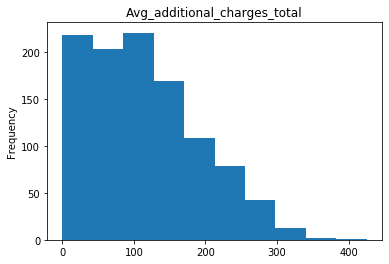

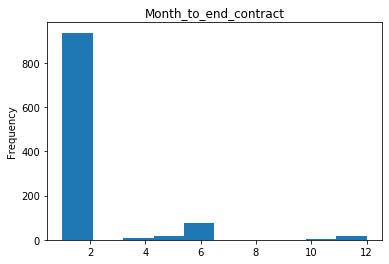

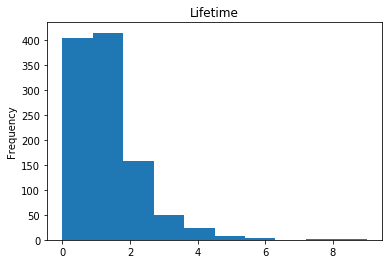

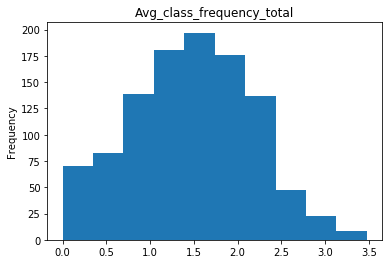

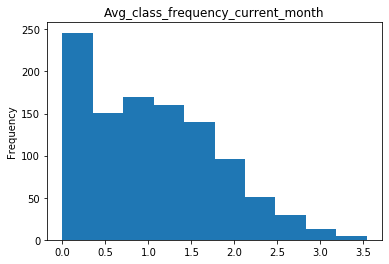

In [10]:
feature_hist(df_churn)

Вызовем функцию для оставшихся клиентов.

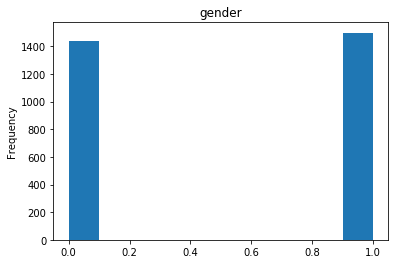

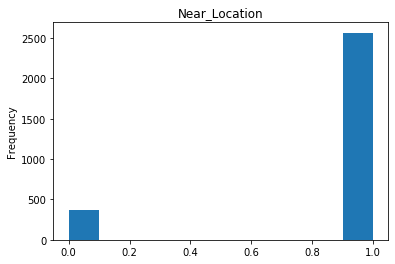

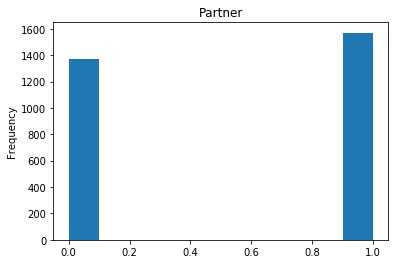

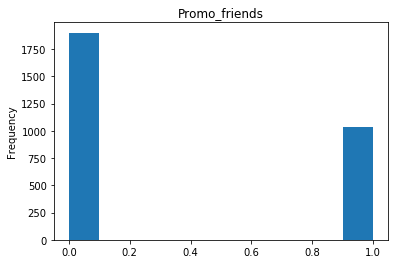

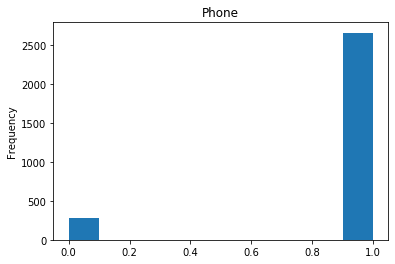

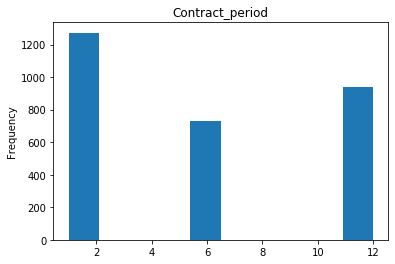

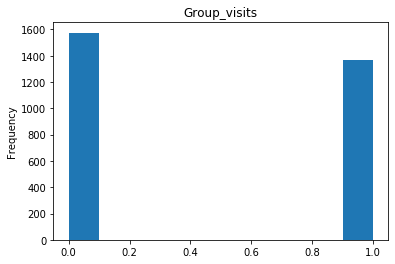

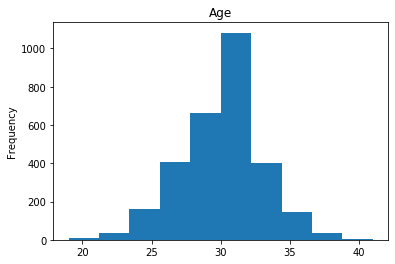

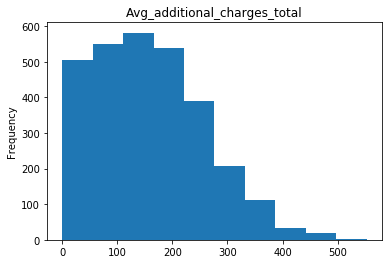

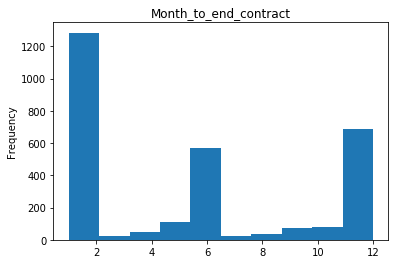

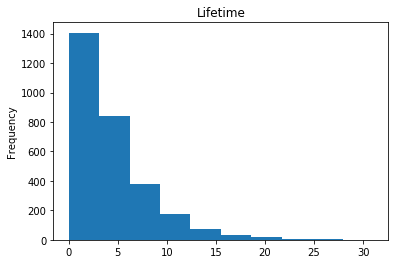

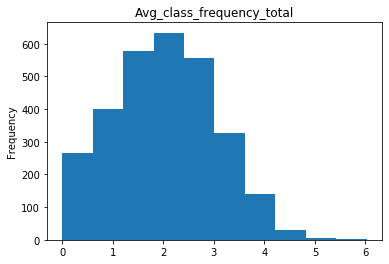

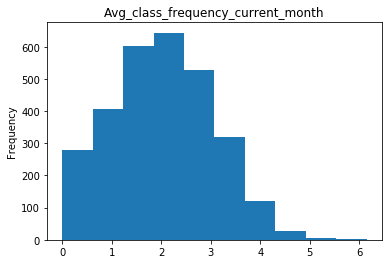

In [11]:
feature_hist(df_stay)

Нормальные данные, аномалий не видим.

### 2.4. Матрица корреляции признаков

Построим матрицу корреляций для полного набора данных.

In [12]:
cm = df.corr()
cm

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


Для наглядности отобразим матрицу как тепловую карту.

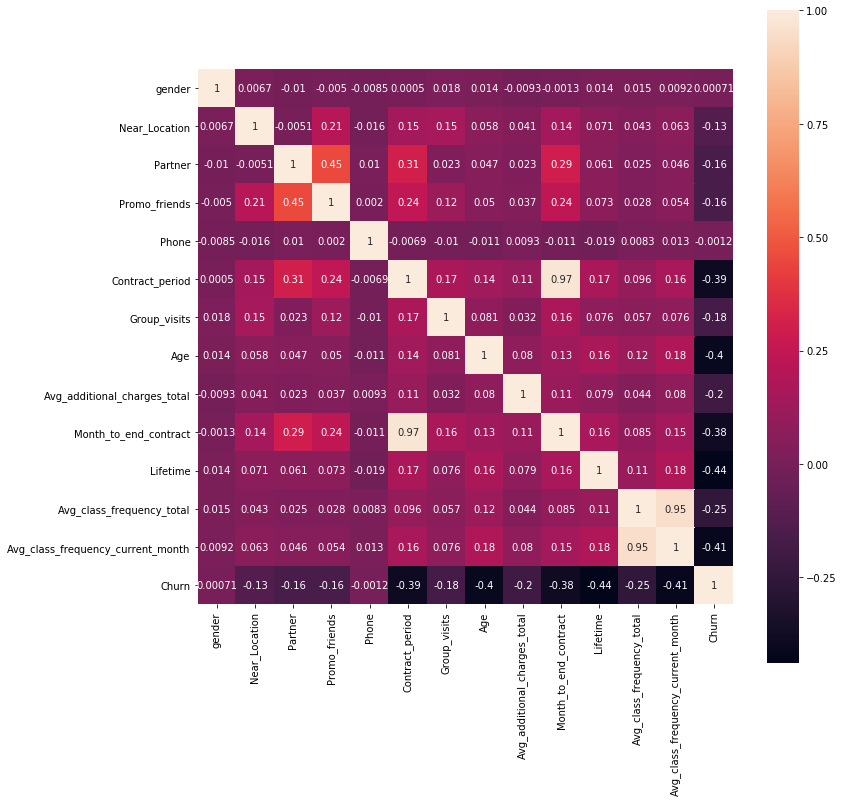

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm, annot = True, square=True)
plt.show()

Из тепловой карты видим две пары сильно коррелирующих признаков:
1. Month_to_end_contract и Contract_period
1. Avg_class_frequency_total и Avg_class_frequency_current_month

Чтобы избавиться от мультиколинеарности, оставим только по одному признаку из пары. Выберем те, что сильнее коррелируют с целевой переменной Churn. Это Contract_period и Avg_class_frequency_current_month. Удалим, соответственно, Month_to_end_contract и Avg_class_frequency_total.

In [14]:
df = df.drop(columns=['Month_to_end_contract', 'Avg_class_frequency_total'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(2), int64(10)
memory usage: 375.1 KB


### Вывод

Провели исследовательский анализ данных. 

По описательным статистикам сделали вывод о том, что данные соотносятся с реальностью и не имеют пропусков.

По средним значениям признаков в двух группах — тех, кто ушел в отток и тех, кто остался - сделали предварительное предположение о том, как какие признаки могут влиять на отток.

Построили столбчатые гистограммы и распределения признаков для тех же двух групп, убедились в нормальности данных.

На основе матрицы корреляций выявили мультиколинеарность данных и устранили ее.

## Шаг 3. Модель прогнозирования оттока пользователей

План действий:

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:
* Разобьем данные на обучающую и валидационную выборку функцией train_test_split().
* Обучим модель на train-выборке двумя способами:
 * логистической регрессией
 * случайным лесом
* Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Ответим на вопрос, какая модель показала себя лучше на основании метрик.

Не забудем указать параметр random_state при разделении выборки и задании алгоритма.

### 3.1. Разбивка данных на обучающую и валидационную выборки

Разделим наши данные на признаки (матрица X) и целевую переменную (y).

In [15]:
X = df.drop('Churn', axis=1)
y = df['Churn']

Разобьем модель на обучающую и валидационную выборки в соотношении 80% к 20%. Зададим параметр random_state = 0 для удобства проверки проекта.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 3.2. Обучение моделей

Сравним обучение моделей двумя способами:
* логистической регрессией
* случайным лесом

Зададим список моделей.

In [17]:
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

Зададим функцию, которая принимает на вход модель и данные и выводит метрики. Нас интересуют метрики accuracy, precision и recall.

In [18]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

Напишем цикл, который выводит метрики по списку моделей.

In [19]:
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.90
Precision: 0.79
Recall: 0.79

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy: 0.89
Precision: 0.80
Recall: 0.74



Метрики довольно близки. Логистическая регрессия дает лучшую долю правильных ответов и полноту, а случайный лес - большую точность. 

В случае прогноза оттока клиентов нам важнее полнота: лучше проработать клиента, который может не уйти, чем потерять его. По этой причине для прогноза будем использовать логистическую регрессию.

### Вывод

Построили две модели бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце. Сравнили обученные модели по метрикам accuracy, precision и recall. Модель с использованием логистической регрессии дает лучшие оценки accuracy и recall. В контексте прогнозирования оттока клиентов фитнес-клуба метрика recall является для нас ключевой, поэтому предпочтем модель логистической регрессии.

Таким образом, теперь мы можем предсказывать отток клиентов, передав обученной модели данные по ним за текущий месяц. Доля правильных ответов будет составлять 90%, точность 79%, полнота 79%.

## Шаг 4. Кластеризация пользователей

Проведем кластеризацию объектов (пользователей). План действий:
* Отложим в сторону столбец с оттоком и стандартизируем данные.
* Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположим, какое количество кластеров можно выделить.
* Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы наши результаты можно было сравнивать с результатами остальных студентов. 
* Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
* Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?
* Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

### 4.1. Стандартизация данных

Зададим матрицу признаков, убрав из данных столбец с оттоком.

In [20]:
X = df.drop('Churn', axis=1)

Создадим объект класса StandardScaler и применим его к матрице признаков.

In [21]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### 4.2. Дендрограмма

Сохраним в переменной linked таблицу «связок» между объектами.

In [22]:
linked = linkage(X_sc, method = 'ward')

Визуализируем связки как дендрограмму.

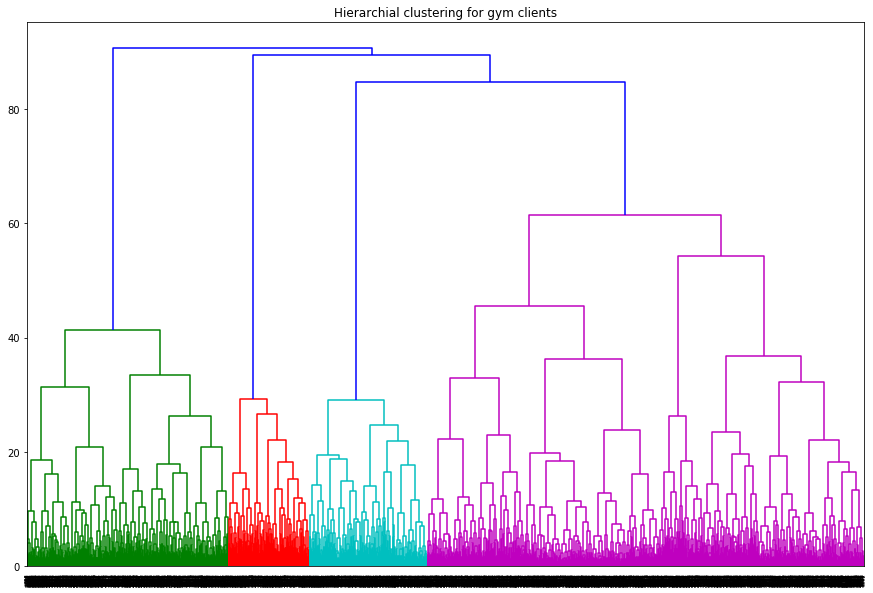

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for gym clients')
plt.show()

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике. Однако лиловый кластер довольно крупный - его вполне можно разбить на два. Для дальнейшего обучения модели примем число кластеров равным 5.

### 4.3. Кластеризация на основании алгоритма K-Means

Зададим модель k_means с числом кластеров 5.

In [24]:
km = KMeans(n_clusters = 5, random_state=0)

Спрогнозируем кластеры для наблюдений и сохраним метки кластера в поле нашего датасета.

In [25]:
labels = km.fit_predict(X_sc)

In [26]:
df['cluster_km'] = labels

### 4.4. Средние значения признаков для кластеров

Сгруппируем данные по кластерам и посчитаем среднее для каждого признака в кластере.

In [27]:
df.groupby(['cluster_km']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


Что можем сразу заметить по средним значениям признаков в кластерах:
* В кластер 1 попали только те клиенты, которые живут далеко от клуба.
* Все клиенты в кластере 0 пришли по рекомендации друзей, и здесь же большинство пользуются партнерскими скидками.
* В кластер 4 попали клиенты, не указавшие телефон.

Главный признак - показатель оттока - имеет наибольшее среднее в кластерах 1 и 2. Для этих кластеров характерны меньший срок действия абонемента, отсутствие рефералов (как друзей, так и партнерских скидок), меньший интерес к групповым занятиям. А вот местонахождение клуба влияет не так, как ожидалось: в кластере 1 ни один клиент не проживает рядом с клубом, а в кластере 2 все клиенты проживают рядом.

### 4.5. Распределения признаков для кластеров

Отобразим распределения признаков с разбивкой по кластерам. Для этого одним циклом будем перебирать колонки, другим кластера.

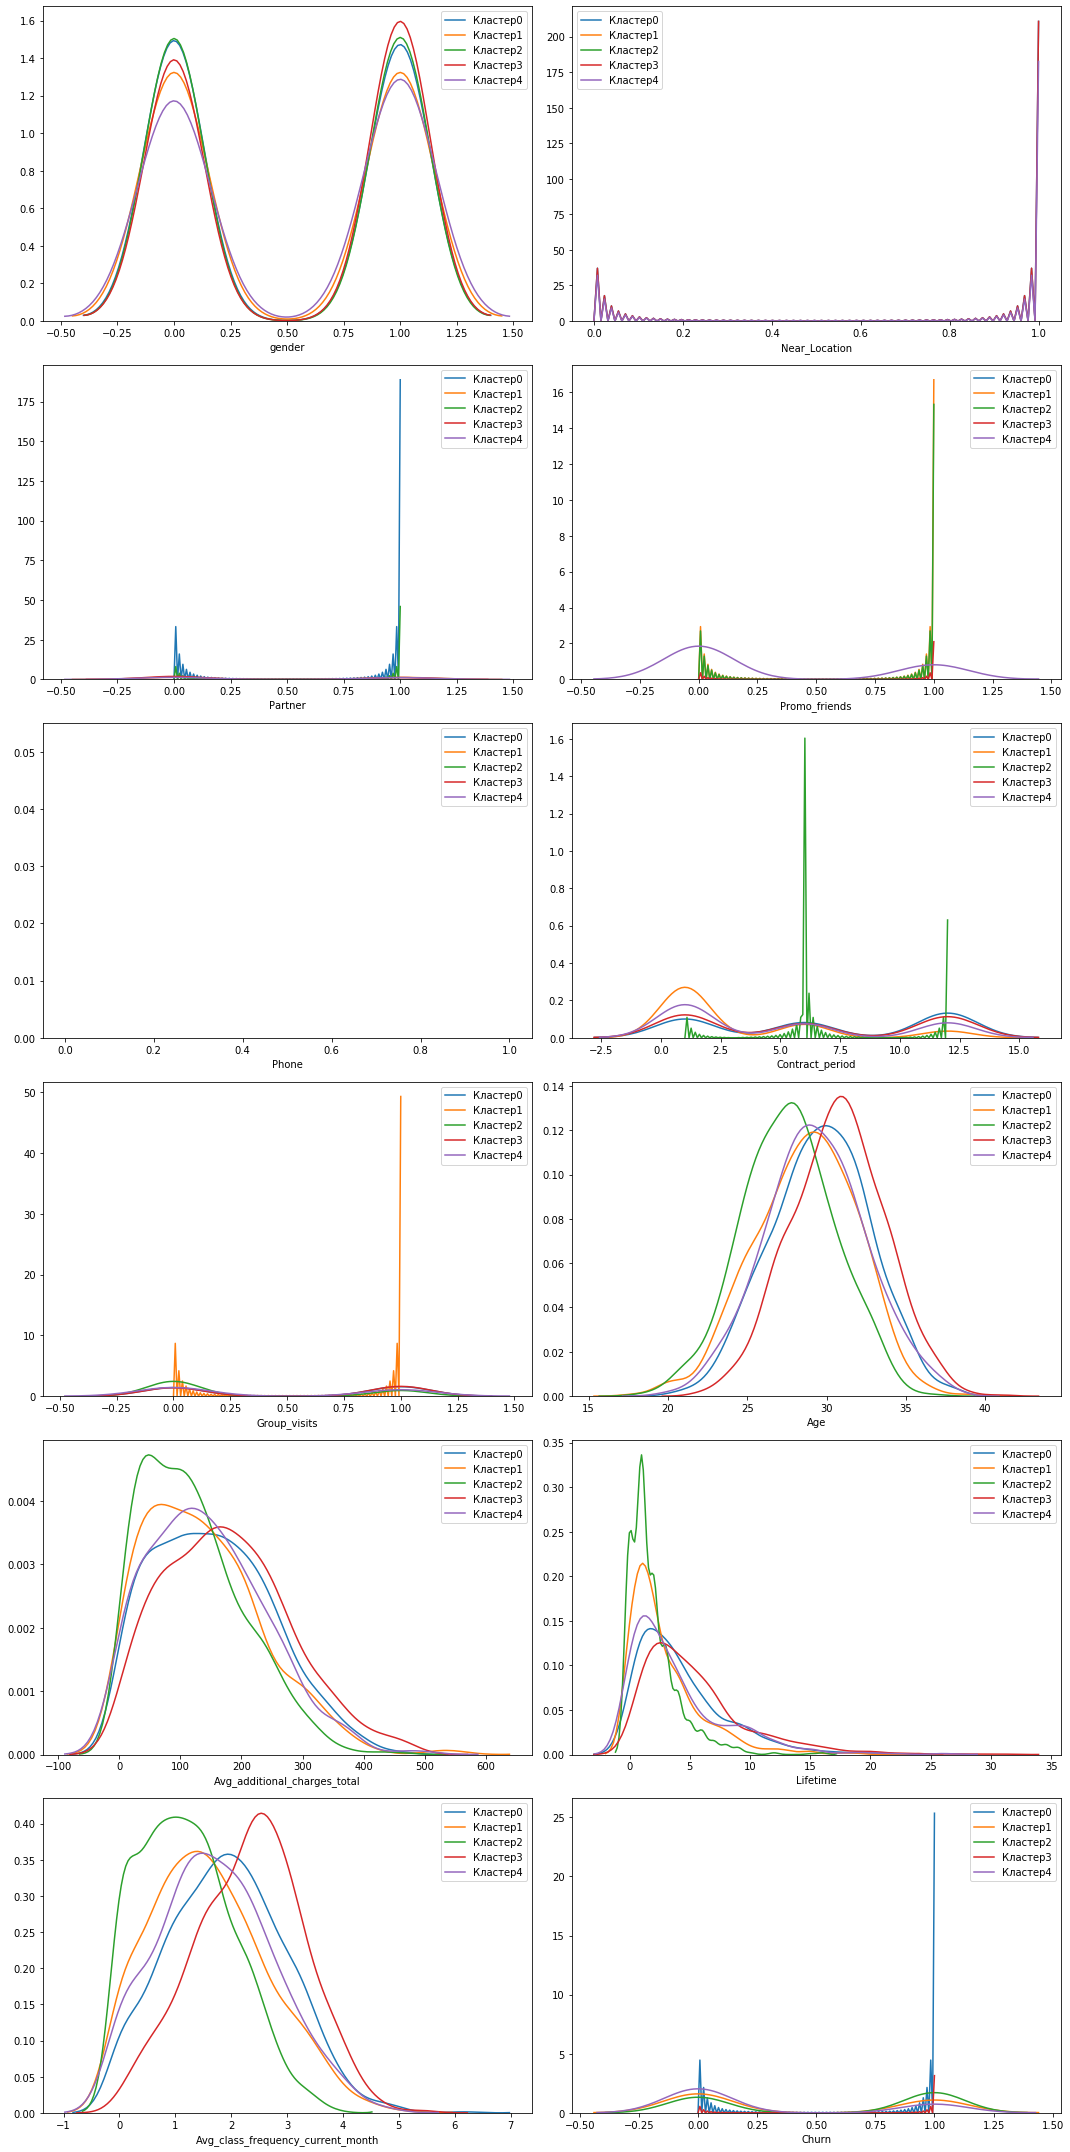

In [28]:
n_columns = df.shape[1]

plt.figure(figsize=(15,30))
for i in range(n_columns-1):
    plt.subplot(6,2,i+1)
    for j in range(5):
        sns.distplot(df.query('cluster_km == @j').loc[:, df.columns.to_list()[i]],
                    hist=False,
                    kde_kws={'label': 'Кластер'+ str(j)})
plt.tight_layout()

Не все из графиков распределений показательны. Однако видим, что каждый признак имеет схожие расперделения для основной массы кластеров, и отличающееся для одного или двух. Например, признак Avg_class_frequency_current_month имеет различия в распределении для кластеров 2 и 3.

### 4.5. Доля оттока по кластерам

Еще раз сгруппируем данные по кластерам и оценим долю оттока в каждом из них.

In [29]:
df.groupby(by='cluster_km')['Churn'].mean()

cluster_km
0    0.119797
1    0.403226
2    0.563910
3    0.014896
4    0.266839
Name: Churn, dtype: float64

Видим, что кластера 0, 3 и 4 надежны, а кластера 1 и 2 склонны к оттоку.

### 4.6. Портреты пользователей в каждом кластере

Составим более подробные портреты клиентов фитнес-клуба по кластерам. Для этого воспользуемся средними значениями признаков и из распределениями, которые мы уже получили.

#### Кластер 0

* Это лояльные клиенты: доля оттока одна из минимальных и составляет 12%.
* Живут рядом с фитнес-клубом.
* Больше всех пользуются партнерскими предложениями и все поголовно пришли по рекомендации друзей.
* Заключают контракт на самый большой срок: 6 и более месяцев.
* Достаточно активно посещают групповые занятия: 52% кластера.

Резюме: кластер 0 - это активные посетители клуба, которые пользуются предложениями и имеют поддержку в своем окружении.

#### Кластер 1

* Это клиенты, склонные к оттоку: по прогнозу в следующем месяце уйдут 40% кластера.
* Живут далеко от фитнес-клуба
* Почти не пользуются партнерскими скидками и рекомендациями друзей.
* Заключают контракт на небольшой период: в среднем 3 месяца.
* Мало интересуются групповыми занятиями.
* Посещают клуб как раз уже почти 3 месяца.

Резюме: кластер 1 - это люди, которые решили попробовать фитнес в данном клубе. Возможно, им не зашло из-за расстояния или отсутствия соратников. Возможно, менеджеры не предложили продлить контракт.

#### Кластер 2

* Это клиенты, наиболее склонные к оттоку: прогноз отттока 56%.
* Живут рядом с клубом.
* Почти не пользуются партнерскими скидками и рекомендациями друзей.
* Заключают контракт на минимальный период: в среднем 2 месяца.
* Мало посещают групповые занятия.
* Это кластер самых молодых клиентов: в среднем 27 лет.
* Покупают меньше всех дополнительных услуг.
* Посещают клуб как раз уже почти 2 месяца.

Резюме: кластер 2 - это самые молодые клиенты, которые решили попробовать фитнес в данном клубе. Более вероятно, что им не захотелось остаться из-за отсутствия соратников. Возможно, менеджеры не предложили продлить контракт.

#### Кластер 3

* Это самые лояльные клиенты: доля оттока 1,5%.
* Живут рядом с клубом.
* Редко пользуются скидками, почти не пользуются приглашениями друзей.
* Заключают контракт на большой срок: от 6 месяцев.
* Активнее всех посещают групповые занятия: 53% клиентов в кластере.
* Самый старший кластер.
* Тратят больше всех на дополнительные услуги.

Резюме: в кластере 3 самые любимые клиенты. Это люди, которым нравится инфраструктура клуба.

#### Кластер 4

* Это "середнячки" по доле оттока: она составляет 27%.
* В основном живут рядом с клубом.
* Пользвуются скидками и приглашениями.
* Ни один из клиентов кластера не указал номер телефона.
* Довольно большой срок контракта: в среднем 4 месяца.

Резюме: единственная характерная черта этих клиентов - отстутствие телефона для связи. Как видим, особо не влияет на показатель оттока.

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами

Сформулируем основные выводы и предложим рекомендации для стратегии взаимодействия с пользователями и их удержания.

В результате проделанной работы мы получили следующее:

1. Научились прогнозировать вероятность оттока для каждого клиента. Для этого данные по клиентам на текущий месяц мы передаем модели логистической регрессии.
2. Сформировали типичные портреты пользователей, поделив их на 5 групп. Часть групп более склонна к оттоку, часть менее. Таким образом мы можем прогнозировать группы по данным на текущий месяц. Клиентам из групп с большей вероятностью оттока можно высылать персональные предложения, например.
3. Выделили признаки, наиболее сильно влияющие на отток. Это: меньший срок действия абонемента, отсутствие рефералов, меньший интерес к групповым занятиям. 

Исходя из признаков, влияющих на отток, можно предложить такие действия:
* Проработать вопрос непродления абонементов, которые оформлялись на короткий срок. Возможно, клиенты расскажут, что им не понравилось.
* Продвигать абонементы с более длительным сроком действия.
* Поощрать реферальную программу, чтобы клиенты приводили больше друзей.
* Развивать направление групповых занятий.